In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
    INDEX_TO_SCENARIO
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_metadata_artefacts,
    load_odds,
    join_metadata,
    build_empty_dataframe,
    apply_final_treatment,
)
from GameProbs import GameProbs
from utils import get_scenarios
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
metadata, gameid_to_outcome = load_metadata_artefacts("data/metadata-with-date.parquet")
odds = load_odds("data/odds.parquet")
print(metadata.shape)
print(odds.shape)

(16869, 9)
(2003933, 7)


In [15]:
pd.to_datetime(pd.read_parquet('data/metadata-with-date.parquet')['Datetime']).dt.date

0        2019-04-27
1        2019-04-27
2        2019-04-27
3        2019-04-28
4        2019-04-28
            ...    
16933    2022-11-13
16934    2022-11-13
16935    2022-11-13
16936    2022-11-13
16937    2022-11-13
Name: Datetime, Length: 16938, dtype: object

In [239]:
metadata[metadata.Datetime.apply(str).str.contains('2021-11-25')]

,League,GameId,Home,Away,Home_score,Away_score,Round,Datetime,Outcome
1099,Brasileirão Série A,5254909,Fluminense,Internacional,1,0,Rodada 35,2021-11-25 00:30:00+00:00,1 : 0
1100,Brasileirão Série A,5254942,São Paulo,Athletico-PR,0,0,Rodada 34,2021-11-25 00:30:00+00:00,0 : 0
1101,Brasileirão Série A,5254913,Santos,Fortaleza,2,0,Rodada 35,2021-11-25 22:00:00+00:00,2 : 0
1102,Brasileirão Série A,5254908,Ceará,Corinthians,2,1,Rodada 35,2021-11-25 23:00:00+00:00,2 : 1
2649,Brasileirão Série B,5254919,Cruzeiro,Náutico,0,0,Rodada 38,2021-11-25 23:00:00+00:00,0 : 0
8542,Liga Conferência,5525882,FC Flora Tallinn,Partizan Belgrado,1,0,Rodada 5,2021-11-25 15:30:00+00:00,1 : 0
8543,Liga Conferência,5525871,Kairat,Basel,2,3,Rodada 5,2021-11-25 15:30:00+00:00,2 : 3
8544,Liga Conferência,5525878,FK Karabakh,AC Omonia,2,2,Rodada 5,2021-11-25 17:45:00+00:00,2 : 2
8545,Liga Conferência,5525879,HJK Helsinquia,Alashkert FC,1,0,Rodada 5,2021-11-25 17:45:00+00:00,1 : 0
8546,Liga Conferência,5525875,Lincoln Red Imps,FC Copenhaga,0,4,Rodada 5,2021-11-25 17:45:00+00:00,0 : 4


In [240]:
import pickle
games_ids = list(set(odds['GameId']))
with open('games_ids.pickle','wb') as f:
    pickle.dump(games_ids, f)

## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [241]:
metadata[metadata.GameId=='4698338']

,League,GameId,Home,Away,Home_score,Away_score,Round,Datetime,Outcome
481,Brasileirão Série A,4698338,Botafogo,Santos,0,0,Rodada 11,2020-09-20 21:15:00+00:00,0 : 0


In [242]:
GAME_ID = "4698338" # Chapecoense x Flamengo
my_game = GameProbs(GAME_ID) 
df = my_game.build_dataframe()
df

,0,1,2,3,4,5,6
0,0.0785,0.0900,0.0587,0.0267,0.0095,0.0028,0.0009
1,0.0879,0.1200,0.0749,0.0347,0.0126,0.0038,0.0013
2,0.0578,0.0755,0.0567,0.0241,0.0088,0.0027,0.0009
3,0.0273,0.0364,0.0251,0.0144,0.0044,0.0014,0.0005
4,0.0104,0.0141,0.0098,0.0047,0.0026,0.0005,0.0002
5,0.0034,0.0046,0.0033,0.0016,0.0006,0.0004,0.0001
6,0.0013,0.0018,0.0013,0.0006,0.0002,0.0001,0.0001


In [243]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet',
                   'Megapari Sport',
                   '22Bet',
                   'Betfair',
                   '888sport',
                   'Betway',
                   '1xBit',
                   'Marathonbet',
                   'NetBet',
                   'Betobet',
                   '18Bet',
                   'Mr Green Sport',
                   'Parimatch',
                   'Bet365']
#odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]
#odds_sample = odds[(odds.GameId==GAME_ID)]

# Join metadata info to the odds dataframe
odds_sample = join_metadata(odds, metadata)
print(odds_sample.shape)

(2003933, 10)


In [244]:
#odds_sample.groupby(['Datetime']).nunique()

In [245]:
#odds_sample[odds_sample.Datetime.apply(str).str.contains('2022-11-13')].GameId.unique()

In [264]:
for group_name, group_data in (odds_sample.groupby(['Datetime']))[:3]:
    games_ids = group_data['GameId'].unique()
    for game_id in games_ids:
        
        print(games_ids)

TypeError: unhashable type: 'slice'

In [ ]:
odds_sample = odds[(odds.GameId==game_id)]
odds_sample = join_metadata(odds_sample, metadata)

df = GameProbs(game_id).build_dataframe()

odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)

In [218]:
odds_sample

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime
0,4698338,LeoVegas Sport,exact,0 : 0,o,10.500000,0.095238,Botafogo,Santos,2020-09-20 21:15:00+00:00
1,4698338,LeoVegas Sport,exact,0 : 1,o,9.000000,0.111111,Botafogo,Santos,2020-09-20 21:15:00+00:00
2,4698338,LeoVegas Sport,exact,0 : 2,o,12.500000,0.080000,Botafogo,Santos,2020-09-20 21:15:00+00:00
3,4698338,LeoVegas Sport,exact,0 : 3,o,25.000000,0.040000,Botafogo,Santos,2020-09-20 21:15:00+00:00
4,4698338,LeoVegas Sport,exact,0 : 4,o,61.000000,0.016393,Botafogo,Santos,2020-09-20 21:15:00+00:00
...,...,...,...,...,...,...,...,...,...,...
1418,4698338,Bovada,over/under,2.5,over,1.909091,0.523809,Botafogo,Santos,2020-09-20 21:15:00+00:00
1419,4698338,Bovada,over/under,2.5,under,1.909091,0.523809,Botafogo,Santos,2020-09-20 21:15:00+00:00
1420,4698338,Bovada,h2h,,h,2.600000,0.384615,Botafogo,Santos,2020-09-20 21:15:00+00:00
1421,4698338,Bovada,h2h,,r,3.350000,0.298507,Botafogo,Santos,2020-09-20 21:15:00+00:00


In [219]:
odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)
odds_sample

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime,BetMap,real_prob,bet_flag
37,4698338,LeoVegas Sport,over/under,4.5,over,6.50,0.153846,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.1550,True
118,4698338,1xBet,over/under,5.5,over,14.50,0.068966,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.0729,True
204,4698338,22Bet,over/under,5.5,over,14.50,0.068966,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.0729,True
357,4698338,Betsson,spread,+2/-2,away,15.00,0.066667,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.0681,True
393,4698338,Marathonbet,over/under,2.5,over,2.00,0.500000,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, ...",0.5071,True
434,4698338,888sport,over/under,4.5,over,6.50,0.153846,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.1550,True
462,4698338,Betfair,exact,0 : 4,o,101.00,0.009901,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0104,True
510,4698338,Betfair,over/under,3.5,over,3.40,0.294118,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.3027,True
512,4698338,Betfair,over/under,4.5,over,7.00,0.142857,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.1550,True
518,4698338,Betfair,spread,-2/+2,away,15.00,0.066667,Botafogo,Santos,2020-09-20 21:15:00+00:00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.8345,True


## Bet Allocation (F2)

In [46]:
odds_sample = odds_sample[odds_sample.Market.isin(['spread', 'over/under', 'h2h', 'exact', 'both_score'])].reset_index(drop=True)
print(odds_sample.shape)

(22, 12)


In [47]:
n = len(odds_sample)
allocation_array = np.round(np.array(((1/n), ) * n), 4)
allocation_array

array([0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
       0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
       0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455])

In [10]:
#df_log = build_empty_dataframe(7, 7, 0)

In [11]:
#odds_sample_favorable['allocation_array'] = allocation_array

In [59]:
#allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample,
                                             num_simulations=10000,
                                             allocation_array=allocation_array)
financial_return_array                                             

sampled_result: 4 : 2 ---- financial_return: 0.0
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 1 : 2 ---- financial_return: 0.0
sampled_result: 4 : 3 ---- financial_return: 0.0
sampled_result: 3 : 2 ---- financial_return: 0.0
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 0 : 1 ---- financial_return: 0.395
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 2 : 2 ---- financial_return: 0.0
sampled_result: 1 : 1 ---- financial_return: 0.0
sampled_result: 4 : 0 ---- financial_return: 0.395
sampled_result: 4 : 1 ---- financial_return: 0.0
sampled_result: 0 : 0 ---- financial_return: 0.395
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 0 : 0 ---- financial_return: 0.395
sampled_result: 1 : 0 ---- financial_return: 0.395
sampled_result: 2 : 2 ---- financial_return: 0.0
sampled_result: 1 : 1 ---- financial_return: 0.

array([0.   , 0.395, 0.   , ..., 0.   , 0.395, 0.   ])

In [60]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

1.4250665000000005
5.984123765270715


In [14]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
#1.5011996815226962/2.148751477147124
1.198463568761181/0.792960103082686

1.5113794049688918

In [48]:
gameid_to_outcome[GAME_ID]

'0 : 0'

In [51]:
odds_sample.iloc[[9,10,11,12]]

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
9,4698338,Betfair,spread,-2/+2,away,15.0,0.066667,Botafogo,Santos,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.8345,True
10,4698338,Betfair,spread,-1/+1,away,5.5,0.181818,Botafogo,Santos,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.6405,True
11,4698338,Betfair,spread,+2/-2,home,15.0,0.066667,Botafogo,Santos,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...",0.8261,True
12,4698338,Betfair,spread,+1/-1,home,5.5,0.181818,Botafogo,Santos,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.6322,True


In [50]:
from utils import get_scenarios
x = get_scenarios(odds_sample.BetMap[0])
#y = get_scenarios(odds_sample.BetMap[21])
x

['0 : 5',
 '0 : 6',
 '1 : 4',
 '1 : 5',
 '1 : 6',
 '2 : 3',
 '2 : 4',
 '2 : 5',
 '2 : 6',
 '3 : 2',
 '3 : 3',
 '3 : 4',
 '3 : 5',
 '3 : 6',
 '4 : 1',
 '4 : 2',
 '4 : 3',
 '4 : 4',
 '4 : 5',
 '4 : 6',
 '5 : 0',
 '5 : 1',
 '5 : 2',
 '5 : 3',
 '5 : 4',
 '5 : 5',
 '5 : 6',
 '6 : 0',
 '6 : 1',
 '6 : 2',
 '6 : 3',
 '6 : 4',
 '6 : 5',
 '6 : 6']

In [54]:
event_i = odds_sample.BetMap[11]
#event_j = odds_sample.BetMap[21]
np.array(event_i).reshape(7,7)

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]])

In [17]:
event_i = odds_sample.BetMap[3]
event_j = odds_sample.BetMap[21]
print(np.transpose(np.array(event_i).reshape(7,7)) * np.transpose(np.array(event_j).reshape(7,7)) * df.to_numpy())

[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0347 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]]


In [12]:
odds_favorable = np.array(odds_sample['Odd'])
real_prob_favorable = np.array(odds_sample['real_prob'])
#scenario_favorable = np.array(odds_sample_favorable['Bet'])
event_favorable = list(odds_sample['BetMap'].values)

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, event_favorable, df)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 1.033942046
my_second_moment: 4.071687487311822
my_sigma: 1.7328160123986494


## Financial Return (F3)

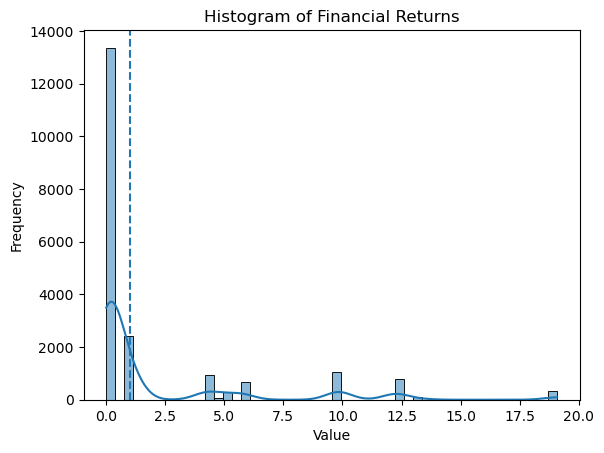

In [18]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=50, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [20]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [73]:
allocation_array

array([0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667,
       0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667])

In [74]:
compute_objective_via_analytical(x=allocation_array,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 event=event_favorable,
                                 df_prob=df)

-0.5966831092291014

In [23]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [13]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               event=event_favorable,
                               df_prob=df)

Optimization terminated successfully.
         Current function value: -1.691665
         Iterations: 6
         Function evaluations: 272
         Gradient evaluations: 17


In [14]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

2.2668526474811657e-05
0.9999999999999999


In [15]:
solution

array([0.14905274, 0.0068798 , 0.00129588, 0.50750173, 0.14905257,
       0.00690143, 0.00163466, 0.00677314, 0.00129588, 0.00701102,
       0.00163466, 0.14528758, 0.00703324, 0.00701102, 0.00163466])

In [16]:
odds_sample = odds_sample[['Market', 'Scenario', 'Bet', 'Sportsbook', 'Odd', 'public_prob', 'real_prob']].assign(solution=solution).sort_values(['solution'], ascending=False)
odds_sample
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Market,Scenario,Bet,Sportsbook,Odd,public_prob,real_prob,solution
3,over/under,1.5,under,LVBET,2.70,0.370370,0.3753,0.507502
0,over/under,2.5,over,Bet365,2.75,0.363636,0.3690,0.149053
4,over/under,2.5,over,Betsson,2.75,0.363636,0.3690,0.149053
11,over/under,2.5,over,Betclic,2.73,0.366300,0.3690,0.145288
12,over/under,3.5,over,Betclic,5.40,0.185185,0.1874,0.007033
13,over/under,3.5,over,NordicBet,5.45,0.183486,0.1874,0.007011
9,over/under,3.5,over,Betsafe,5.45,0.183486,0.1874,0.007011
5,over/under,3.5,over,Betsson,5.70,0.175439,0.1874,0.006901
1,over/under,3.5,over,Bet365,5.75,0.173913,0.1874,0.006880
7,over/under,3.5,over,Betfair,6.00,0.166667,0.1874,0.006773


In [22]:
teste = odds_sample.loc[[0, 4, 11, 1, 5, 9, 12, 13, 2, 8, 7]]
sum(teste['Odd'] * teste['solution'])

1.4840529585770648